This model follows the logic from `run_forced_moving_obj_1D` but with rigid body dynamics for the robotic arm.

Our state-space $\mathbf{x} \in \mathbb{R}^6 $ includes torques $\tau_i$, angles $\theta_i$ and angular velocities $\dot{\theta}_i$. We append all static parameters in $\phi = \{L_{1}, L_{2}, M_{1}, M_{2}\}$.

$$
\mathbf{x} = \begin{pmatrix} \mathbf{x}_1 = \tau_1 \\  \mathbf{x}_2 = \tau_2 \\ \mathbf{x}_3 =\theta_1 \\ \mathbf{x}_4 =\theta_2 \\
\mathbf{x}_5 = \dot{\theta}_1 \\ \mathbf{x}_6 = \dot{\theta}_2 \end{pmatrix}  
$$

$$
\mathbf{\dot{x}} = \begin{pmatrix} 0 \\  0 \\ \mathbf{x}_5 \\ \mathbf{x}_6 \\ \mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}  
\end{pmatrix}  := a(\mathbf{x})
$$

Where $\mathbf{D} \in \mathbb{R}^{2 \times 2}$ is the inertia tensor.

Note that $a(\mathbf{x})$ is non-linear because of the operation $\mathbf{D}^{-1}(\mathbf{x}_4, \phi) \begin{pmatrix} \mathbf{x}_1 \\ \mathbf{x}_2 \end{pmatrix}$.

with noise on the torque

$$
\mathbf{\dot{x}} = a(\mathbf{x}) + \begin{pmatrix} 1 \\ 1 \\ 0 \\ 0\\0\\0\end{pmatrix} \nu, \quad \nu \sim \mathcal{N}(0,1)
$$

with Euler discretizetion 

$$
\mathbf{x}_{t+\Delta{t}} = \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ 0 \\ 0 \\ 0 \\0 \end{pmatrix} \nu_t \approx \mathbf{x}_t + \Delta{t}a(\mathbf{x}_t) + \begin{pmatrix} \Delta{t} \\ \Delta{t} \\ \sigma \\ \sigma \\ \sigma \\\sigma \end{pmatrix} \nu_t
 $$

where we introduce $\sigma<<\Delta{t}$ to avoid a degenerate distribution.
So our transition is defined as follows:

$$
f(\mathbf{x}_{t+\Delta{t}}|\mathbf{x}_t) = \mathcal{N}(\mathbf{x}_t + \Delta{t}a(\mathbf{x}_t), \text{diag}(\Delta{t}^2,\Delta{t}^2, \sigma, \sigma, \sigma, \sigma))
$$

The emission is 

$$
g(\mathbf{y}_t | \mathbf{x}_t) = \text{FW-KIN}(\mathbf{x}_3, \mathbf{x}_4)
$$

In [39]:
import os
print(os.getcwd())
plot_folder = 'planar_arm_dyn_plots'

/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test


In [40]:
# change dir to import from aesmc
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc")
import aesmc.statistics as statistics
import aesmc.inference as inference
import aesmc.train as train
import aesmc.losses as losses
import aesmc.state as state

In [41]:
# change dir to import from aesmc/test
os.chdir("/Users/danbiderman/Dropbox/Columbia/1.Dan/John/aesmc/test")
from arm_models import planar_arm_dyn_model # the model script -- distribution objects are defined there
from arm_models import arm_utils # make video, plot post, params to coords

In [42]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

In [43]:
# matplotlib general settings 
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [8.0, 6.0]
mpl.rcParams['font.size'] = 12
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'

mpl.rcParams['lines.linewidth'] = 4.0

In [44]:
# define global params which we're not ineferring 
dt = 0.03
transition_aux_scale = (dt**2)/3.0 # was 0.01. testing to see if it helps to make smaller
transition_force_scale = 1.0 # ToDo: currently not used; if desired, change model script
# proposal_scale_0 = 1
# proposal_scale_t = 0.1
initial_loc = 0.0 # inside model script it is expanded to 3d
initial_scale = 0.1 # same here.
# define train/infer params
num_timesteps = 200
test_inference_num_particles = 1000
saving_interval = 10
logging_interval = 10
batch_size = 10
num_iterations = 500
num_particles = 100
g = 0
inits_dict = {}
inits_dict["L1"] = 2.0
inits_dict["L2"] = 2.0
inits_dict["M1"] = 1.1
inits_dict["M2"] = 1.2
emission_scale = (inits_dict["L1"] + inits_dict["L2"])/(2.0*2.0*10.0)
print(emission_scale)

0.1


In [45]:
initial = planar_arm_dyn_model.Initial(initial_loc, initial_scale)
transition = planar_arm_dyn_model.Transition(dt, inits_dict, 
                                             transition_force_scale, 
                                             transition_aux_scale, g)
emission = planar_arm_dyn_model.Emission(inits_dict, emission_scale)

torch.Size([6, 6])


In [46]:
# define proposal here.
proposal = planar_arm_dyn_model.Bootstrap_Proposal( \
                                dt, inits_dict, \
                                initial_scale, initial_loc, \
                                transition_force_scale, \
                                transition_aux_scale, g)

In [47]:
np.random.seed(0)
torch.manual_seed(0)

In [48]:
sim_lats , sim_observs = statistics.sample_from_prior(initial,
                                transition,
                                emission, 
                                num_timesteps,
                                batch_size)
print(sim_lats[-1].size()) # [batch_size, dim_latents]
print(sim_observs[-1].size()) # [batch_size, dim_obs]

torch.Size([10, 6])
torch.Size([10, 6])


In [49]:
lat_data = torch.cat([lat.unsqueeze(-1) for
                           lat in sim_lats], dim=2)
print(lat_data.shape) # [batch_size, dim_latents, num_timesteps]
sim_data = torch.cat([obs.unsqueeze(-1) for
                           obs in sim_observs], dim=2)
print(sim_data.shape)

torch.Size([10, 6, 200])
torch.Size([10, 6, 200])


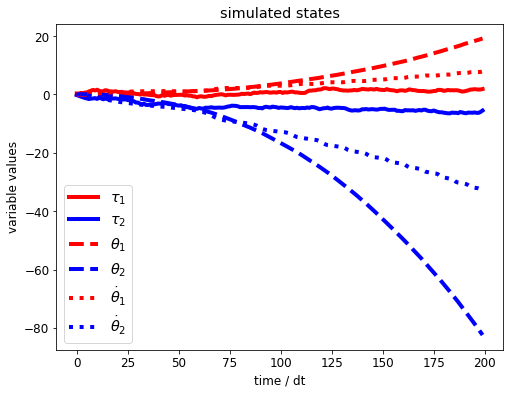

In [50]:
ind_in_batch = 5 # could be between 0 and batch_size-1
plt.plot(lat_data[ind_in_batch,0,:].detach().numpy(), 'red', 
         label=r"$\tau_1$");
plt.plot(lat_data[ind_in_batch,1,:].detach().numpy(), 'blue', 
         label = r"$\tau_2$");
plt.plot(lat_data[ind_in_batch,2,:].detach().numpy(), 'red', 
         linestyle = "dashed", label = r"$\theta_1$");
plt.plot(lat_data[ind_in_batch,3,:].detach().numpy(), 'blue', 
         linestyle = 'dashed', label = r"$\theta_2$");
plt.plot(lat_data[ind_in_batch,4,:].detach().numpy(), 'red', 
         linestyle = "dotted", label = r"$\dot{\theta}_1$");
plt.plot(lat_data[ind_in_batch,5,:].detach().numpy(), 'blue', 
         linestyle = 'dotted', label = r"$\dot{\theta}_2$");
# plt.plot(sim_data[ind_in_batch,0,:].detach().numpy(), 'black', 
#           label = r"$y_1 =  \theta_1 + \epsilon$", linestyle = 'dashdot');#plt.plot(smooth_var[ind_in_batch,dim_lat_plot,:].detach().numpy(), 'gray'); # 0! it's also not on the same scale
# plt.plot(sim_data[ind_in_batch,1,:].detach().numpy(), 'black', 
#           label = r"$y_2 =  \theta_2 + \epsilon$", linestyle = ':');         
plt.title('simulated states')
plt.ylabel('variable values')
plt.xlabel('time / dt')
plt.legend();
plt.savefig(plot_folder+'/sim_data_vis.png')

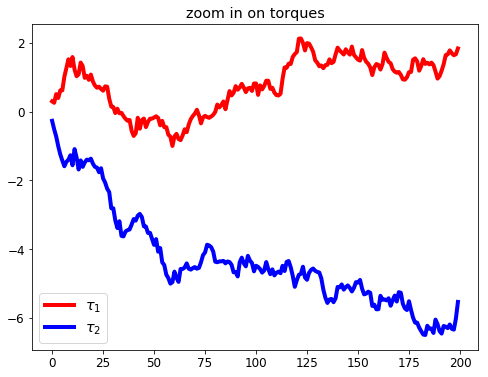

In [51]:
plt.title('zoom in on torques')
plt.plot(lat_data[ind_in_batch,0,:].detach().numpy(), 'red', 
         label=r"$\tau_1$");
plt.plot(lat_data[ind_in_batch,1,:].detach().numpy(), 'blue', 
         label = r"$\tau_2$");
plt.legend();

In [52]:
inference_result = inference.infer(
            inference_algorithm='smc',
            observations=sim_observs, 
            initial=initial,
            transition=transition,
            emission=emission,
            proposal=proposal,
            num_particles=250,
            return_log_weights=True,
        )

In [53]:
# extract mean and variance of the latents
smc_smoothed_state_means = []
smc_smoothed_state_variances = []
for latent in inference_result['latents']:
    smc_smoothed_state_means.append(statistics.empirical_mean(
        latent, inference_result['log_weight']
    ))
    smc_smoothed_state_variances.append(statistics.empirical_variance(
        latent, inference_result['log_weight']
    ))

In [54]:
# Note: we extracted sim_data and lat_data above
smooth_mean =  torch.cat([mean.unsqueeze(-1) for
                           mean in smc_smoothed_state_means], dim=2)
smooth_var = torch.cat([var.unsqueeze(-1) for
                           var in smc_smoothed_state_variances], dim=2)

In [55]:
# transform to numpy arrays once
sim_data_np = sim_data.detach().numpy()
lat_data_np = lat_data.detach().numpy()
smooth_mean_np = smooth_mean.detach().numpy()
smooth_var_np = smooth_var.detach().numpy()

In [56]:
smooth_mean_np.shape

(10, 6, 200)

In [57]:
label_list = [r'$\tau_1$', r'$\tau_2$', 
              r'$\theta_1$', r'$\theta_2$',
             r'$\dot{\theta}_1$', r'$\dot{\theta}_2$']

/anaconda3/envs/pytorch_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in sqrt
  if __name__ == '__main__':


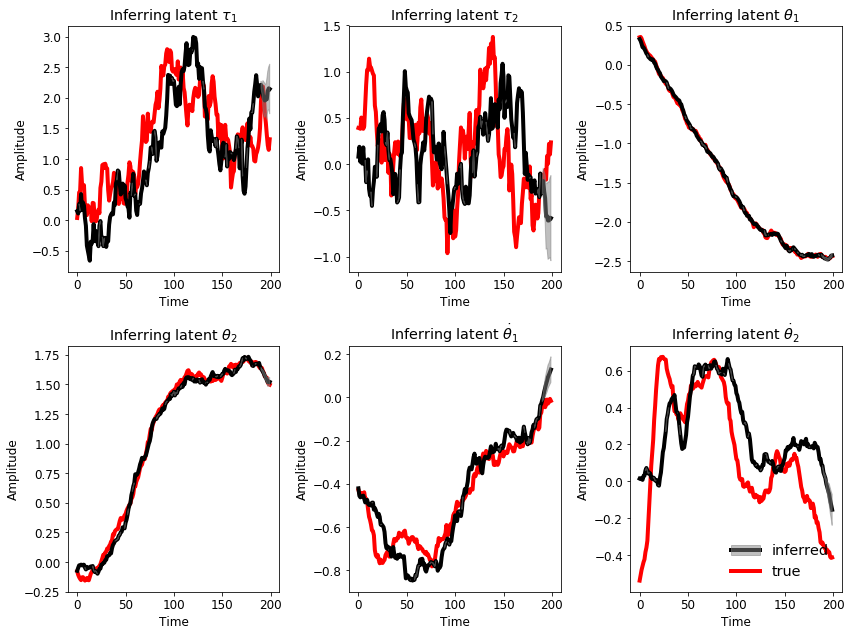

In [75]:
ind_in_batch = 2
fig, axs = plt.subplots(2, 3, figsize=(12, 9))#, share_y = True)
axs = axs.flatten()
plt_leg = False
for i in range(smooth_mean_np.shape[1]):
    if i ==5:
        plt_leg = True
    arm_utils.plot_posterior_trace(post_mean = smooth_mean_np[ind_in_batch,i,: ], 
                     post_var = np.sqrt(smooth_var_np[ind_in_batch,i,: ]), 
                     data_vec = lat_data_np[ind_in_batch,i,:], 
                     alpha = 0.5, plot_legend=plt_leg, 
                     plot_uncertainty=True, plot_true_data=True, 
                     legends_list = ["inferred",
                                        "true"], 
                     legend_loc = "lower right", 
                         title = "Inferring latent " + label_list[i] , 
                     xlabel = 'Time', ylabel = 'Amplitude', fig_fullname = None, 
                     ax = axs[i]);
fig.tight_layout()
plt.savefig(plot_folder+'/BPF_infer_latents.png')

In [67]:
x_obs = sim_data_np[ind_in_batch, [0,2,4], :].T
y_obs = sim_data_np[ind_in_batch, [1,3,5], :].T
print(y_obs.shape)

(200, 3)


In [60]:
# TODO: make sure to input right params for learning
x_hat , y_hat = arm_utils.coords_from_params_mat(
   smooth_mean_np[ind_in_batch,2,:], 
    smooth_mean_np[ind_in_batch,3,:], 
                inits_dict["L1"], inits_dict["L2"]) 
x_hat.shape

(200, 3)

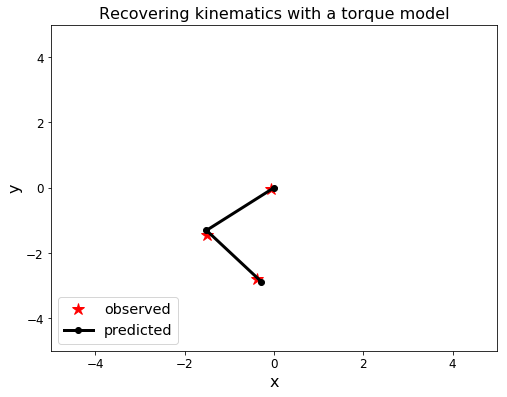

In [61]:
arm_utils.video_sim_plane_2D(x_obs, y_obs, 
                             x_hat, y_hat, 
                             plot_folder+'/recover_dyn', 
                   "Recovering kinematics with a torque model", 
                             x_hat.shape[0], inits_dict["L1"] + 
                             inits_dict["L2"] + 1)

In [68]:
# we're looking at one batch
print(inference_result['log_weights'][-1].shape)
log_weights =  torch.cat([weights.unsqueeze(-1) for
                           weights in inference_result["log_weights"]],
                         dim=2)
ws = log_weights[ind_in_batch,:,:].detach().numpy()
print(ws.shape)

torch.Size([10, 250])
(250, 200)


In [69]:
median = np.median(ws, axis=0)
variance = np.var(ws, axis = 0)

Text(0, 0.5, 'median log weight')

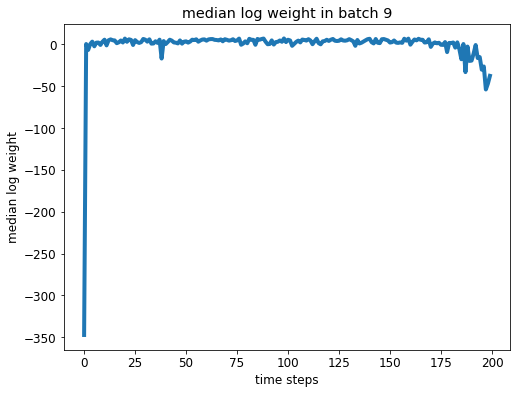

In [70]:
plt.plot(median)
plt.title('median log weight in batch %s' %str(ind_in_batch))
plt.xlabel('time steps')
plt.ylabel('median log weight')